<a href="https://colab.research.google.com/github/hhboorstein/ds_portfolio/blob/main/Santander_Customer_Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='top'></a>

![Santander Logo](https://www.santanderbank.com/documents/330006/330008/logo+%281%29.png/ca903dab-71ae-9b33-0bab-05c7d754b18f?t=1600208431481&download=true)

# Santander Customer Satisfaction

### Notebook in progress!

Data is from the 2016 [Banco Santander competition](https://www.kaggle.com/competitions/santander-customer-satisfaction/overview) on Kaggle.

Cyphered customer data is supplied with the goal of predicting customer satisfaction. The target flag is encoded:
* 1: Unsatisfied,
* 0: Not expilcitly unsatisfied.

(From the perspective of philosophy of logic, the above encoding reflects our rejection of the Law of Excluded Middle for this binary classification. That is to say, it is possible for a customer to be labelled in class 0 without being unconditionally satisfied. Ultimately though, this is just semantic quibbling in the spirit of Wittgenstein, not Russell.)


###Table of Contents

[Setup](#setup)

[Model Evaluation Functions](#model-eval-funcs)

[Vanilla Models](#vanilla)

[Oversampled Models](#oversampled-models)

[Model Tuning](#tuning)

<a name='setup'></a>
# Setup

[Skip to data preprocessing.](#data-pre)

## Update Libraries

Running the lastest builds of:
* scikit-learn
* imbalanced-learn
* XGBoost
* LightGBM
* CatBoost

In [1]:
! pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install -U xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! pip install -U lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 23.1 MB/s eta 0:00:00


In [5]:
! pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Libraries

In [42]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from xgboost import cv as XGB_CV
from xgboost import DMatrix

#plotting
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# cluster analysis
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier

# processing pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [7]:
sns.set_theme()

## Read Data

We import our data, stored as an Apache parquet file.

In [8]:
bank=pd.read_parquet('santander_train.parquet')
data=bank.copy()

In [9]:
bank.shape

(76020, 371)

We have around 76k records with 371 features.

In [14]:
bank.sample(10,random_state=1)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
14162,28459,2,25,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46969.410000,1
35732,71476,2,33,0.0,930.21,1391.55,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,307194.780000,0
24191,48386,2,25,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109659.060000,0
10440,20945,2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71302.530000,0
46585,93165,2,24,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
46064,92159,2,25,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103667.040000,0
27661,55359,2,62,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,195088.740000,0
36671,73262,2,41,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59630.010000,0
70885,141557,158,65,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83606.940000,0
72468,144712,2,24,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74988.840000,0


The only recognizable columns are the ID column and the TARGET column. The rest of the attributes are cyphered, according to the source linked above.

In [ ]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


The data frame requires around 215 MB of memory.

In [ ]:
# null check
bank.isna().sum().sum()

0

In [ ]:
# duplicate row check
bank.duplicated().sum()

0

There are no null entries or duplicated rows.

In [16]:
bank['TARGET'].value_counts(normalize=True)

0    0.960431
1    0.039569
Name: TARGET, dtype: float64

This dataset is massively imbalanced, with only 4% of records in the positive class. Thankfully, most of our customers are not unsatisfied. On the other hand, this imbalance will make detection and modeling more delicate.

<a name='data-pre'></a>
## Data Preprocessing

### Split

We separate the data into predictive features and our target. Then we split into training data and validation data. There is no need to reserve data for final evaluation, as we have that data stored in a separate file.

In [10]:
X=bank.drop(['ID','TARGET'],axis=1)
y=bank['TARGET']

In [11]:
# split into training and validation sets
X_train,X_val,y_train,y_val=train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=57
)

We reserve 30% of the data for our validation set.

### Scaling

In order to demonstrate the PCA transformation that follows, we first need to scale our data. Scaling will shortly be incorporated into a preprocessing pipeline, rendering this section redundant.

In [37]:
scaler=StandardScaler().set_output(transform='pandas')

X_ts=scaler.fit_transform(X_train)

In [39]:
X_ts.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
var3,53214.0,5.608072e-18,1.000009,-27.956373,0.035750,0.035750,0.035750,0.042356
var15,53214.0,-2.281951e-16,1.000009,-2.172472,-0.785866,-0.477731,0.446674,5.530898
imp_ent_var16_ult1,53214.0,-6.008649e-18,1.000009,-0.049542,-0.049542,-0.049542,-0.049542,117.774053
imp_op_var39_comer_ult1,53214.0,-5.207496e-18,1.000009,-0.219330,-0.219330,-0.219330,-0.219330,26.065719
imp_op_var39_comer_ult3,53214.0,1.215082e-17,1.000009,-0.220725,-0.220725,-0.220725,-0.220725,38.221859


Note that every attribute has mean approximately 0 and standard deviation approximately 1.

### PCA

Principal Component Analysis is an implementation of eigen decomposition. In effect, it is a coordinate transformation, where the new axes reflect explained variance in the data. Moreover, these axes, or *components*, are ordered decreasingly by explained variance. Many of the components can thus be discarded (off the end), as they generally do not contribute much to the explanation of variance. In this way, PCA can be used for dimension reduction.

In [23]:
print(f'Number of features: {X_ts.shape[1]}.')

Number of features: 369.


Before dimension reduction, we have 369 features in our dataset.

In [24]:
# 10% of features
pca37=PCA(n_components=37)

pca37.fit(X_ts)

PCA(n_components=37)

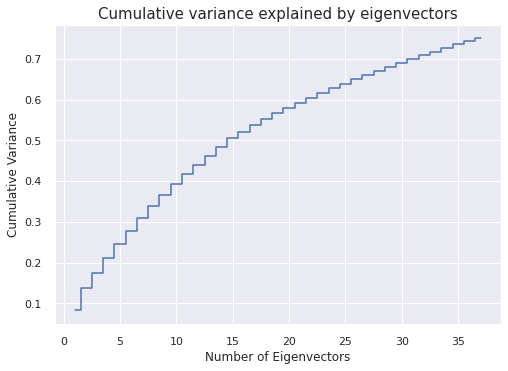

In [25]:
plt.title('Cumulative variance explained by eigenvectors',fontsize=15)
plt.step(
    np.arange(1,38),
    np.cumsum(pca37.explained_variance_ratio_),
    where='mid'
)
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Cumulative Variance');

We find that 37 components explain about 75% of our variance: not enough. Moreover, we can see graphically that the right side of the curve is still increasing, not levelling off. We'll need more components.

We know that 369 features can explain 100% of the variance in our data. Can we get away with fewer?

In [26]:
# 33% of features
pca123=PCA(n_components=123)

pca123.fit(X_ts)

PCA(n_components=123)

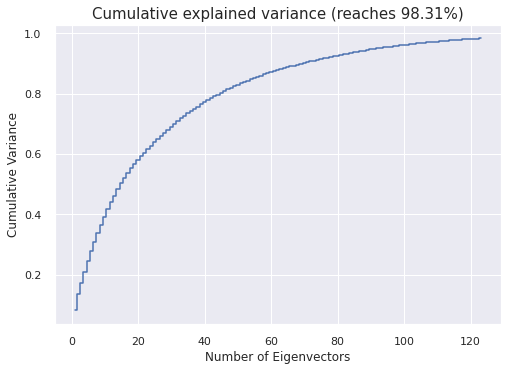

In [27]:
evr=pca123.explained_variance_ratio_

plt.title(f'Cumulative explained variance (reaches {np.round(sum(evr)*100,2)}%)',fontsize=15)
plt.step(
    np.arange(1,124),
    np.cumsum(evr),
    where='mid'
)
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Cumulative Variance');

We can explain nearly 100% of the variance in our data with just a third of the components. This decreases the memory required to store the data and massively reduces computation time during training.

### Pipeline

We now incorporate scaling and PCA into a preprocessing pipeline.

In [12]:
# preprocessing pipe
pre=Pipeline(
    steps=[
        ('Scaler',StandardScaler()),
        ('Dimension_Reduction',PCA(n_components=123))
    ]
).set_output(transform='pandas')

In [13]:
X_ts=pre.fit_transform(X_train)

In [14]:
X_vs=pre.transform(X_val)

We fit the pipeline on our training data and then use it to transform our validation data. This approach ensures the integrity of our analysis by preventing data leakage.

In [15]:
a=X_ts.memory_usage().sum()/X_train.memory_usage().sum()
print(f'Memory usage reduced to {np.round(a*100,2)}% of original data frame.')

Memory usage reduced to 33.51% of original data frame.


As expected, PCA reduced memory usage by nearly 67%.

### Oversampling

In [16]:
y_train.value_counts(normalize=True)

0    0.960424
1    0.039576
Name: TARGET, dtype: float64

In [17]:
smote=SMOTE(
    sampling_strategy='not majority',
    random_state=1,
    k_neighbors=5
)

In [18]:
# oversampled training data
Xt_over,yt_over=smote.fit_resample(X_ts,y_train)

In [19]:
yt_over.value_counts(normalize=True)

0    0.5
1    0.5
Name: TARGET, dtype: float64

In [35]:
Xt_over.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102216 entries, 0 to 102215
Columns: 123 entries, pca0 to pca122
dtypes: float64(123)
memory usage: 95.9 MB


# Cluster Analysis

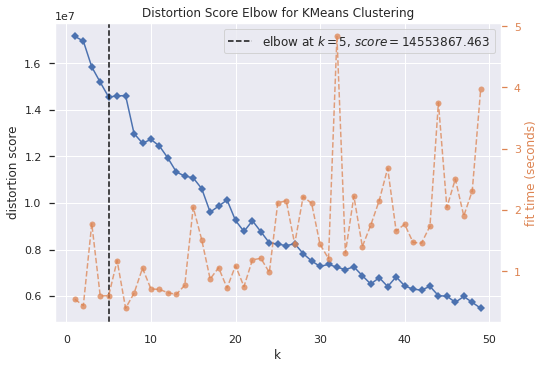

In [ ]:
km=KMeans(
    init='k-means++',
    n_init='auto'
)

vis=KElbowVisualizer(
    estimator=km,
    k=(1,50)
)

vis.fit(X_ts).show();

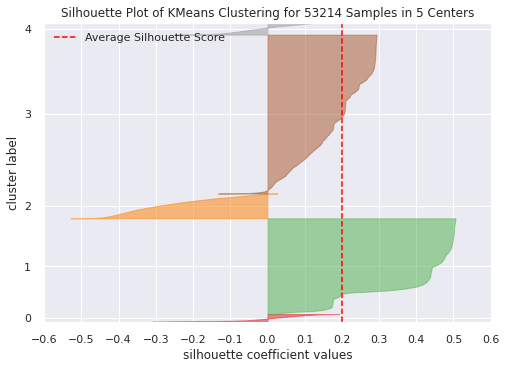

In [ ]:
# 5 clusters
SilhouetteVisualizer(
    estimator=KMeans(
        n_clusters=5,
        init='k-means++',
        n_init='auto'
    )
).fit(X_ts).show();

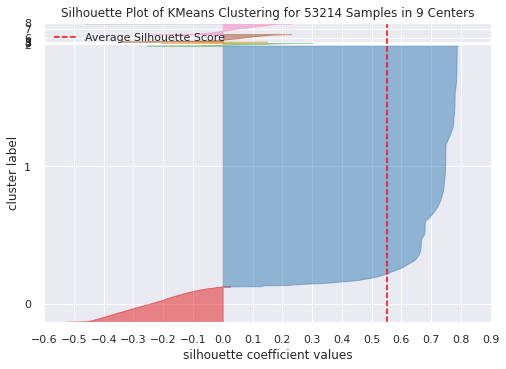

In [ ]:
# 9 clusters
SilhouetteVisualizer(
    estimator=KMeans(
        n_clusters=9,
        init='k-means++',
        n_init='auto'
    )
).fit(X_ts).show();

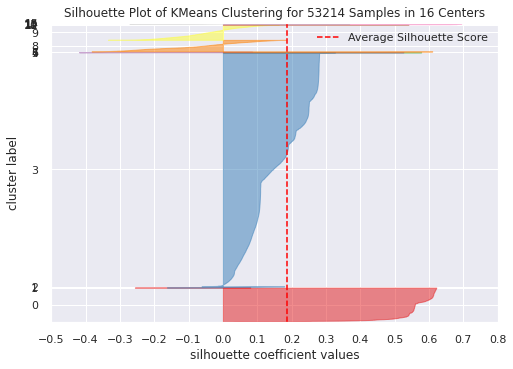

In [ ]:
# 16 clusters
SilhouetteVisualizer(
    estimator=KMeans(
        n_clusters=16,
        init='k-means++',
        n_init='auto'
    )
).fit(X_ts).show();

<a name='model-eval-funcs'></a>
# Model Evaluation Functions

In [20]:
def get_scores(model,sample=None,output=None):
  '''Collect model scores.'''
  
  # define training data
  if sample=='over':
    X_t=Xt_over
    y_t=yt_over
  else:
    X_t=X_ts
    y_t=y_train

  # predictions
  y_t_hat=model.predict(X_t)
  y_v_hat=model.predict(X_vs)

  # collect scores
  train_scores=[
      metrics.recall_score(y_t,y_t_hat),
      metrics.fbeta_score(y_t,y_t_hat,beta=2),
      metrics.f1_score(y_t,y_t_hat),
      metrics.roc_auc_score(y_t,y_t_hat),
      metrics.zero_one_loss(y_t,y_t_hat)
  ]

  val_scores=[
      metrics.recall_score(y_val,y_v_hat),
      metrics.fbeta_score(y_val,y_v_hat,beta=2),
      metrics.f1_score(y_val,y_v_hat),
      metrics.roc_auc_score(y_val,y_v_hat),
      metrics.zero_one_loss(y_val,y_v_hat)
  ]

  # output scores in pandas df
  if output=='pandas':
    df=pd.DataFrame(
        [train_scores,val_scores],
        columns=[
            'Recall',
            'F_beta',
            'F1',
            'AUC',
            '0-1_Loss'
        ],
        index=['train','val']
    )
    return df

  return [train_scores,val_scores]

In [21]:
def confusion_heatmap(model,show_scores=True):
  '''Heatmap of confusion matrix for
  model performance on validation data.'''

  actual=y_val
  predicted=model.predict(X_vs)

  # generate confusion matrix
  cm=metrics.confusion_matrix(actual,predicted)
  cm=np.flip(cm).T

  # heatmap labels
  labels=['TP','FP','FN','TN']
  cm_labels=np.array(cm).flatten()
  cm_percents=np.round((cm_labels/np.sum(cm))*100,3)
  annot_labels=[]
  for i in range(4):
    annot_labels.append(str(labels[i])+'\nCount:'+str(cm_labels[i])+'\n'+str(cm_percents[i])+'%')
  annot_labels=np.array(annot_labels).reshape(2,2)

  # print figure
  plt.figure(figsize=(8,5))
  plt.title('Confusion Matrix (Validation Data)',fontsize=20)
  sns.heatmap(data=cm,
              annot=annot_labels,
              annot_kws={'fontsize':'x-large'},
              xticklabels=[1,0],
              yticklabels=[1,0],
              cmap='Greens',
              fmt='s')
  plt.xlabel('Actual',fontsize=14)
  plt.ylabel('Predicted',fontsize=14)
  plt.tight_layout();

  # scores
  if show_scores==True:
    scores=['Accuracy','Precision','Recall','F1']
    score_list=[metrics.accuracy_score(actual,predicted),
                metrics.precision_score(actual,predicted),
                metrics.recall_score(actual,predicted),
                metrics.f1_score(actual,predicted)]
    df=pd.DataFrame(index=scores)
    df['Val. Scores']=score_list
    return df
  return

# alias function name to something shorter
ch=confusion_heatmap

<a name='vanilla'></a>
# Vanilla Models

Summary of vanilla model testing: No model performed well with default configurations on the regular data. Performance gains are only observed once we train on oversampled data.

[Jump to models trained on oversampled data.](#oversampled-models)

In [ ]:
models=[
    'RandomForest',
    'AdaBoost',
    'XGBoost',
    'LightGBM',
    'CatBoost'
]

datasets=['train','val']

# generate MultiIndex object
mi=pd.MultiIndex.from_product(
    iterables=[models,datasets],
    names=['model','data']
)

In [ ]:
# build comparison table
tab=pd.DataFrame(
    columns=[
        'Recall',
        'F_beta',
        'F1',
        'AUC',
        '0-1_Loss'
    ],
    index=mi
)

The value of $\beta$ in the $F_\beta$ score allows us to bias the score between precision and recall. With $\beta=2$, we give recall twice the importance of precision.

## Dummy Classifier


In [ ]:
d=DummyClassifier(
    strategy='stratified',
    random_state=1
)

d.fit(X_ts,y_train)

DummyClassifier(random_state=1, strategy='stratified')

We fit a dummy classifier to set a performance baseline.

,Val. Scores
Accuracy,0.925809
Precision,0.042824
Recall,0.041020
F1,0.041903


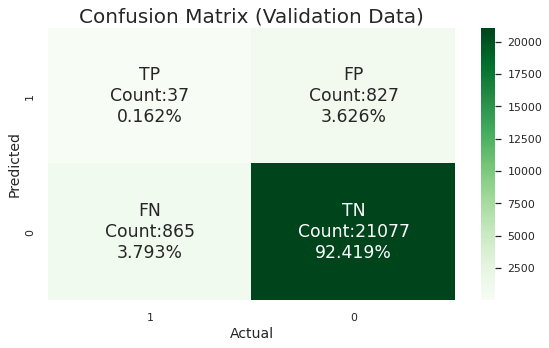

In [ ]:
ch(d)

Predictably, this classifier yields high accuracy on our highly imbalanced data set. Its failing, however, is 4% recall.

## Random Forest

In [ ]:
rf=RandomForestClassifier(
    random_state=1,
    n_jobs=-1
)

rf.fit(X_ts,y_train)

RandomForestClassifier(random_state=1)

In [ ]:
tab.loc['RandomForest']=get_scores(rf)

tab.loc['RandomForest']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.903609,0.920569,0.947237,0.951716,0.003984
val,0.04102,0.04848,0.066667,0.516607,0.045427


Random forest fares better on recall, though this is merely due to overfitting. Validation AUC barely clears the baseline 50%.

,Val. Scores
Accuracy,0.954573
Precision,0.177885
Recall,0.041020
F1,0.066667


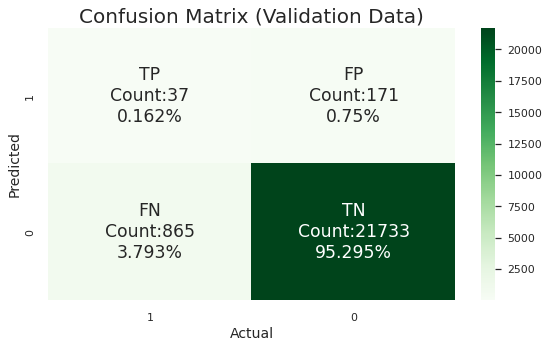

In [ ]:
ch(rf)

We can see from the confusion matrix that the number of true positives detected is **the same** as the dummy classifier. Thus, the only improvement made here is in the classification of true negatives.

## AdaBoost

In [ ]:
abc=AdaBoostClassifier(random_state=1)

abc.fit(X_ts,y_train)

AdaBoostClassifier()

In [ ]:
tab.loc['AdaBoost']=get_scores(abc)

tab.loc['AdaBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.005223,0.006509,0.010319,0.502465,0.039651
val,0.002217,0.002765,0.004396,0.500972,0.039726


On the one hand, AdaBoost is not suffering the same overfitting issues as random forest. On the other, its performance is horrid.

,Val. Scores
Accuracy,0.960274
Precision,0.250000
Recall,0.002217
F1,0.004396


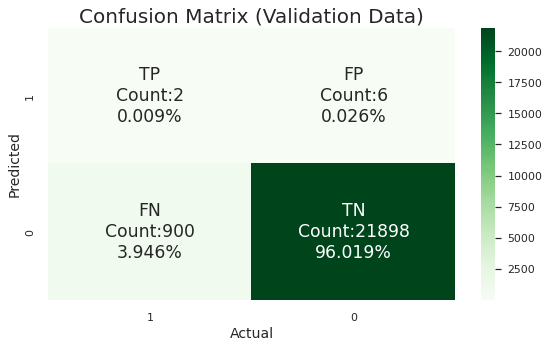

In [ ]:
ch(abc)

The confusion matrix shows that AdaBoost is just predicting 0 for essentially every observation, with only eight predicted in the positive class.

## XGBoost

In [ ]:
xgb=XGBClassifier(
    random_state=1
)

xgb.fit(X_ts,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [ ]:
tab.loc['XGBoost']=get_scores(xgb)

tab.loc['XGBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.38509,0.438805,0.554909,0.692486,0.024448
val,0.015521,0.019141,0.029443,0.506962,0.040472


,Val. Scores
Accuracy,0.959528
Precision,0.285714
Recall,0.015521
F1,0.029443


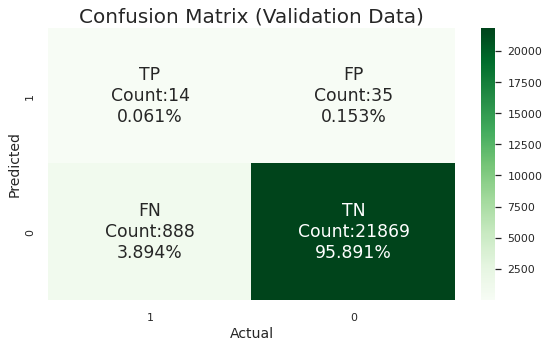

In [ ]:
ch(xgb)

Overfitting plagues XGBoost too. We have yet to see a validation AUC appreciably climb above 50%.

## LightGBM

In [ ]:
lg=LGBMClassifier()

lg.fit(X_ts,y_train)

LGBMClassifier()

In [ ]:
tab.loc['LightGBM']=get_scores(lg)

tab.loc['LightGBM']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.155745,0.187364,0.269405,0.577863,0.033431
val,0.005543,0.006906,0.010941,0.502612,0.039639


,Val. Scores
Accuracy,0.960361
Precision,0.416667
Recall,0.005543
F1,0.010941


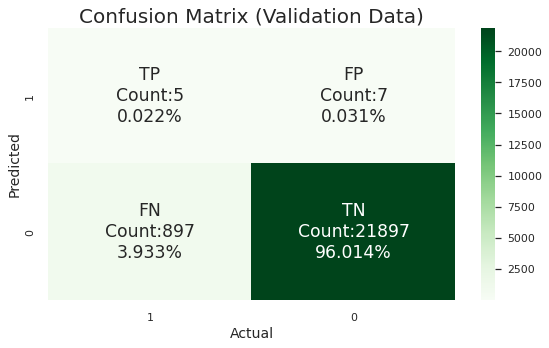

In [ ]:
ch(lg)

Comparable performance can be observed in default LightGBM, with overfitting and poor recall and AUC.

## CatBoost

In [ ]:
cb=CatBoostClassifier()

cb.fit(X_ts,y_train,verbose=False)

In [ ]:
tab.loc['CatBoost']=get_scores(cb)

tab.loc['CatBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.208452,0.247519,0.344314,0.604177,0.03142
val,0.003326,0.004129,0.006472,0.501161,0.040384


,Val. Scores
Accuracy,0.959616
Precision,0.120000
Recall,0.003326
F1,0.006472


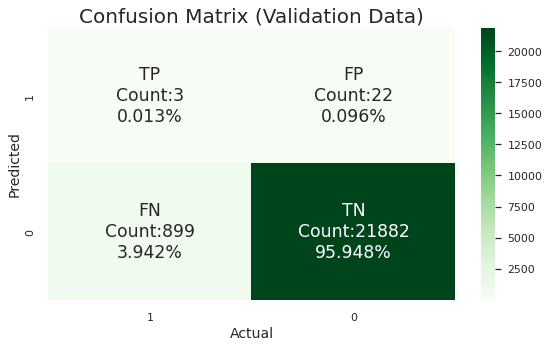

In [ ]:
ch(cb)

CatBoost is similarly deficient.

## Comparison

In [ ]:
tab

Recall    F_beta        F1       AUC  0-1_Loss
model        data                                                   
RandomForest train  0.903609  0.920569  0.947237  0.951716  0.003984
             val     0.04102   0.04848  0.066667  0.516607  0.045427
AdaBoost     train  0.005223  0.006509  0.010319  0.502465  0.039651
             val    0.002217  0.002765  0.004396  0.500972  0.039726
XGBoost      train   0.38509  0.438805  0.554909  0.692486  0.024448
             val    0.015521  0.019141  0.029443  0.506962  0.040472
LightGBM     train  0.155745  0.187364  0.269405  0.577863  0.033431
             val    0.005543  0.006906  0.010941  0.502612  0.039639
CatBoost     train  0.208452  0.247519  0.344314  0.604177   0.03142
             val    0.003326  0.004129  0.006472  0.501161  0.040384

Hyperparameter tuning will not garner the performance improvements we need. Let's instead train the models on oversamed data.

<a name='oversampled-models'></a>
# Oversampled Models

Data oversampling using SMOTE (Synthetic Minority Oversampling TEchnique).

In [ ]:
# build comparison table
tab_over=pd.DataFrame(
    columns=[
        'Recall',
        'F_beta',
        'F1',
        'AUC',
        '0-1_Loss'
    ],
    index=mi
)

## Random Forest

In [ ]:
rf_over=RandomForestClassifier(
    random_state=1,
    n_jobs=-1
)

rf_over.fit(Xt_over,yt_over)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [ ]:
tab_over.loc['RandomForest']=get_scores(rf_over,sample='over')

tab_over.loc['RandomForest']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.990178,0.99024,0.990333,0.990334,0.009666
val,0.299335,0.230572,0.171483,0.604539,0.1144


,Val. Scores
Accuracy,0.885600
Precision,0.120160
Recall,0.299335
F1,0.171483


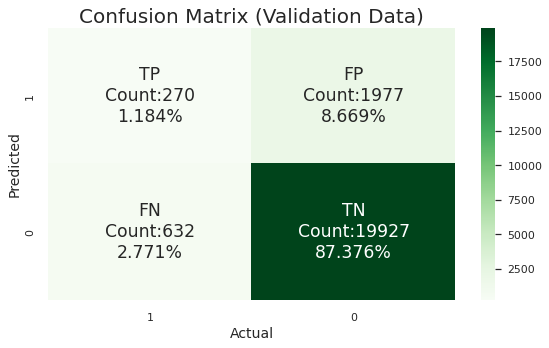

In [ ]:
ch(rf_over)

## AdaBoost

In [ ]:
abc_over=AdaBoostClassifier(random_state=1)

abc_over.fit(Xt_over,yt_over)

AdaBoostClassifier()

In [ ]:
tab_over.loc['AdaBoost']=get_scores(abc_over,sample='over')

tab_over.loc['AdaBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.757748,0.756487,0.754603,0.753581,0.246419
val,0.699557,0.322037,0.177972,0.722906,0.255591


,Val. Scores
Accuracy,0.744409
Precision,0.101955
Recall,0.699557
F1,0.177972


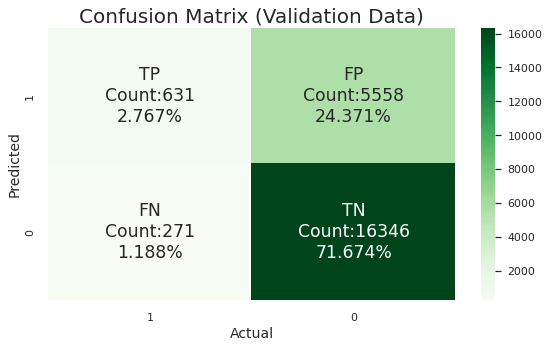

In [ ]:
ch(abc_over)

## XGBoost

In [ ]:
xgb_over=XGBClassifier(
    tree_method='gpu_hist',
    random_state=1
)

xgb_over.fit(Xt_over,yt_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [ ]:
tab_over.loc['XGBoost']=get_scores(xgb_over,sample='over')

tab_over.loc['XGBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.948071,0.936639,0.919998,0.917557,0.082443
val,0.503326,0.322764,0.209845,0.683844,0.149917


,Val. Scores
Accuracy,0.850083
Precision,0.132555
Recall,0.503326
F1,0.209845


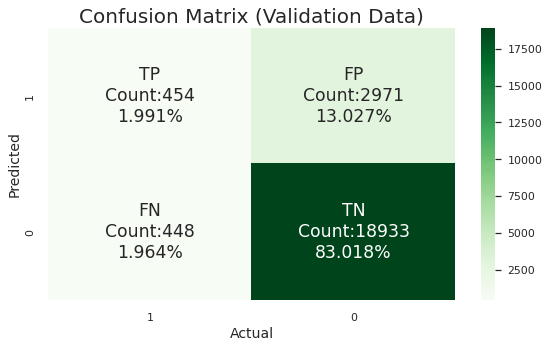

In [ ]:
ch(xgb_over)

Notice here that far fewer false positives yields a higher F1 score than the previous AdaBoost model.

## LightGBM

In [ ]:
lg_over=LGBMClassifier(
    n_jobs=-1,
    random_state=1
)

lg_over.fit(Xt_over,yt_over)

LGBMClassifier(random_state=1)

In [ ]:
tab_over.loc['LightGBM']=get_scores(lg_over,sample='over')

tab_over.loc['LightGBM']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.894811,0.884045,0.868373,0.864366,0.135634
val,0.617517,0.344337,0.206986,0.719208,0.187144


,Val. Scores
Accuracy,0.812856
Precision,0.124330
Recall,0.617517
F1,0.206986


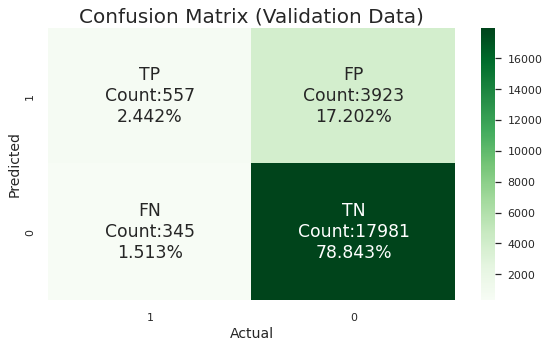

In [ ]:
ch(lg_over)

## CatBoost

In [ ]:
cb_over=CatBoostClassifier(
    task_type='GPU',
    gpu_ram_part=0.9,
    gpu_cat_features_storage='GpuRam',
    random_seed=1
)

cb_over.fit(Xt_over,yt_over,verbose=False)

In [ ]:
tab_over.loc['CatBoost']=get_scores(cb_over,sample='over')

tab_over.loc['CatBoost']

,Recall,F_beta,F1,AUC,0-1_Loss
data,,,,,
train,0.893109,0.883637,0.869801,0.866313,0.133687
val,0.599778,0.342448,0.208357,0.714288,0.18026


,Val. Scores
Accuracy,0.819740
Precision,0.126078
Recall,0.599778
F1,0.208357


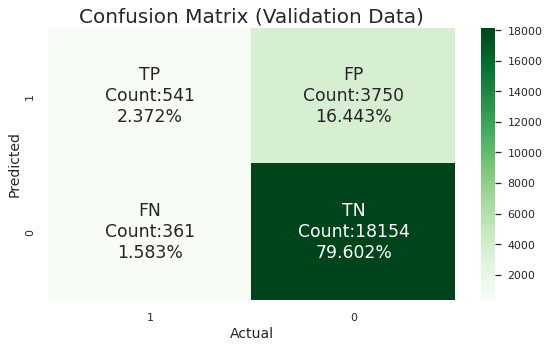

In [ ]:
ch(cb_over)

## Comparison

In [ ]:
tab_over

Recall    F_beta        F1       AUC  0-1_Loss
model        data                                                   
RandomForest train  0.990178   0.99024  0.990333  0.990334  0.009666
             val    0.299335  0.230572  0.171483  0.604539    0.1144
AdaBoost     train  0.757748  0.756487  0.754603  0.753581  0.246419
             val    0.699557  0.322037  0.177972  0.722906  0.255591
XGBoost      train  0.948071  0.936639  0.919998  0.917557  0.082443
             val    0.503326  0.322764  0.209845  0.683844  0.149917
LightGBM     train  0.894811  0.884045  0.868373  0.864366  0.135634
             val    0.617517  0.344337  0.206986  0.719208  0.187144
CatBoost     train  0.893109  0.883637  0.869801  0.866313  0.133687
             val    0.599778  0.342448  0.208357  0.714288   0.18026

* Random forest is massively overfit.

* AdaBoost appears to suffer the least from overfitting. Especially promising is the AUC scores. The validation AUC in particular is higher than any other model in the table.

* XGBoost is plagued by overfitting, but the validation scores show promise. With tuning the overfitting might be controllable.

* LightGBM and CatBoost show near-identical performance in every metric. Still these models require much tuning and improvement.

<a name='tuning'></a>
# Model Tuning

## AdaBoost

In [84]:
params={
    'n_estimators':np.arange(50,251,50),
    'learning_rate':[0.5,1.0,2.0]
}

### Base Estimator: Decision Stump

In [ ]:
abc_tuned1=AdaBoostClassifier(random_state=1)

go1=GridSearchCV(
    estimator=abc_tuned1,
    param_grid=params,
    scoring=['recall','f1','roc_auc'],
    refit='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

go1.fit(Xt_over,yt_over)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=1), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 1.0, 2.0],
                         'n_estimators': array([ 50, 100, 150, 200, 250])},
             refit='roc_auc', return_train_score=True,
             scoring=['recall', 'f1', 'roc_auc'], verbose=1)

In [ ]:
best_abc1=go1.best_params_

best_abc1

{'learning_rate': 1.0, 'n_estimators': 250}

In [ ]:
abc_tuned1=AdaBoostClassifier(
    random_state=1,
    **best_abc1
)

abc_tuned1.fit(Xt_over,yt_over)

AdaBoostClassifier(n_estimators=250, random_state=1)

In [ ]:
get_scores(abc_tuned1,sample='over',output='pandas')

,Recall,F_beta,F1,AUC,0-1_Loss
train,0.798290,0.794921,0.789921,0.787695,0.212305
val,0.675166,0.330511,0.187183,0.723540,0.231913


,Val. Scores
Accuracy,0.768087
Precision,0.108653
Recall,0.675166
F1,0.187183


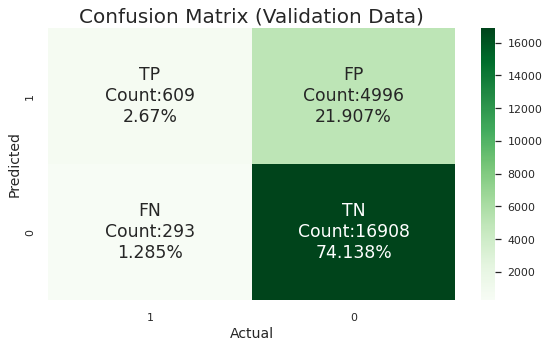

In [ ]:
ch(abc_tuned1)

### Base Estimator: ExtraTreesClassifier

In [88]:
abc_tuned2=AdaBoostClassifier(
    estimator=ExtraTreesClassifier(random_state=2),
    random_state=1
)

go2=GridSearchCV(
    estimator=abc_tuned2,
    param_grid=params,
    scoring=['recall','f1','roc_auc'],
    refit='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

go2.fit(Xt_over,yt_over)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


ERROR:concurrent.futures:exception calling callback for <Future at 0x7fd32c3a5df0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.9/dist-packages/joblib/parallel.py", line 360, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.9/dist-packages/joblib/parallel.py", line 797, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.9/dist-packages/joblib/parallel.py", line 864, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.9/dist-packages/joblib/parallel.py", line 782, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.9/dist-packages/joblib/_parallel_backends.py", line 531, in apply_async
    future = self._workers.submit(SafeFunction(func)

TerminatedWorkerError: ignored

In [ ]:
best_abc2=go2.best_params_

best_abc2

In [ ]:
abc_tuned2=AdaBoostClassifier(
    estimator=ExtraTreesClassifier(random_state=2),
    random_state=1,
    **best_abc2
)

abc_tuned2.fit(Xt_over,yt_over)

In [ ]:
get_scores(abc_tuned2,sample='over',output='pandas')

In [ ]:
ch(abc_tuned2)

## XGBoost


### Grid Search

In [22]:
params={
    'eta':np.linspace(0.05,0.3,6),
    'max_depth':np.arange(2,5),
    'min_child_weight':[1,2],
    'subsample':np.linspace(0.5,0.9,4),
    'colsample_bytree':np.linspace(0.5,0.9,4)
}

In [26]:
xgb_tuned=XGBClassifier(
    tree_method='gpu_hist',
    random_state=1
)

go=GridSearchCV(
    estimator=xgb_tuned,
    param_grid=params,
    scoring=['recall','f1','roc_auc'],
    refit='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start=time.time()
go.fit(Xt_over,yt_over)
print(f'Fit completed in{np.round((time.time()-start)/60,2)} minutes.')

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


1310.4878611564636

In [27]:
best_xgb1=go.best_params_

best_xgb1

{'colsample_bytree': 0.9,
 'eta': 0.3,
 'max_depth': 4,
 'min_child_weight': 1,
 'subsample': 0.7666666666666666}

In [28]:
xgb_tuned1=XGBClassifier(
    tree_method='gpu_hist',
    random_state=1,
    **best_xgb1
)

xgb_tuned1.fit(Xt_over,yt_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

,Val. Scores
Accuracy,0.808165
Precision,0.122089
Recall,0.621951
F1,0.204111


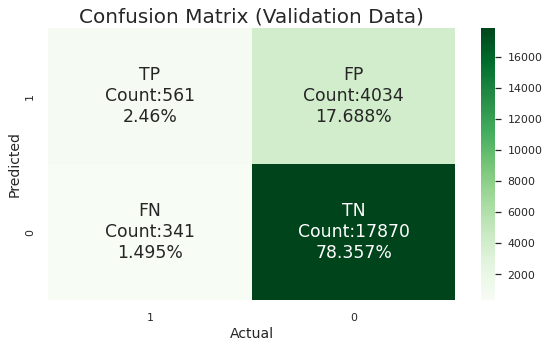

In [29]:
ch(xgb_tuned1)

In [30]:
get_scores(xgb_tuned1,sample='over',output='pandas')

,Recall,F_beta,F1,AUC,0-1_Loss
train,0.889880,0.878905,0.862941,0.858662,0.141338
val,0.621951,0.341948,0.204111,0.718892,0.191835


### CV Analysis

In [47]:
results=go.cv_results_

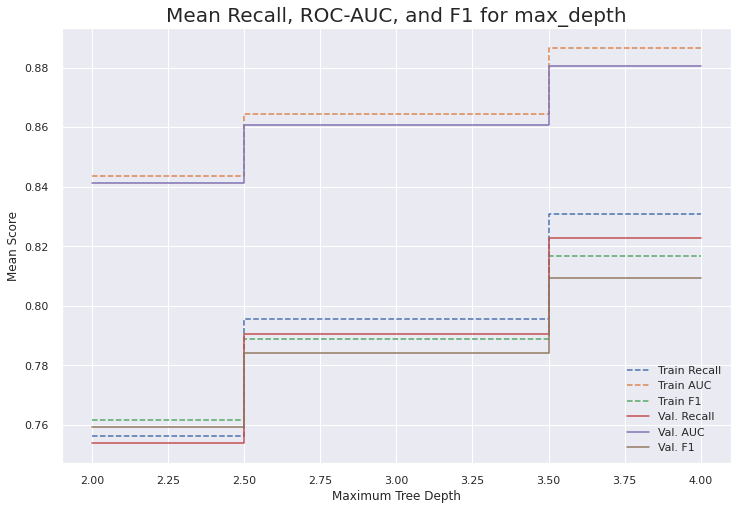

In [87]:
# figure setup
plt.figure(figsize=(12,8))
plt.title('Mean Recall, ROC-AUC, and F1 for max_depth',fontsize=20)

# recall training
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_train_recall']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Train Recall',
         linestyle='--',
         drawstyle='steps-mid')

# AUC training
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_train_roc_auc']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Train AUC',
         linestyle='--',
         drawstyle='steps-mid')

# F1 training
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_train_f1']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Train F1',
         linestyle='--',
         drawstyle='steps-mid')

# recall val
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_test_recall']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Val. Recall',
         drawstyle='steps-mid')

# AUC val
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_test_roc_auc']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Val. AUC',
         drawstyle='steps-mid')

# F1 val
a=pd.DataFrame(
    data=np.array([
        results['param_max_depth'],
        results['mean_test_f1']
    ]).T,
    columns=['depth','']
).groupby('depth').mean().values

plt.plot(np.arange(2,5),
         a,
         label='Val. F1',
         drawstyle='steps-mid')

# axes and legend
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Mean Score')
plt.legend(loc='lower right')

plt.show()

Note that recall and F1 trade places as the dominant metric and `max_depth` increases. When `max_depth=2`, we find F1 is greater than recall (both in training and validation). This inverts when we increment `max_depth`.

Notice further that the vertical gaps between training and validation averages increase with `max_depth`. This indicates that risk of overfitting increases with `max_depth`.

ROC-AUC has the highest scores across the board. It too exhibits the tendancy toward overfitting as `max_depth` increases.

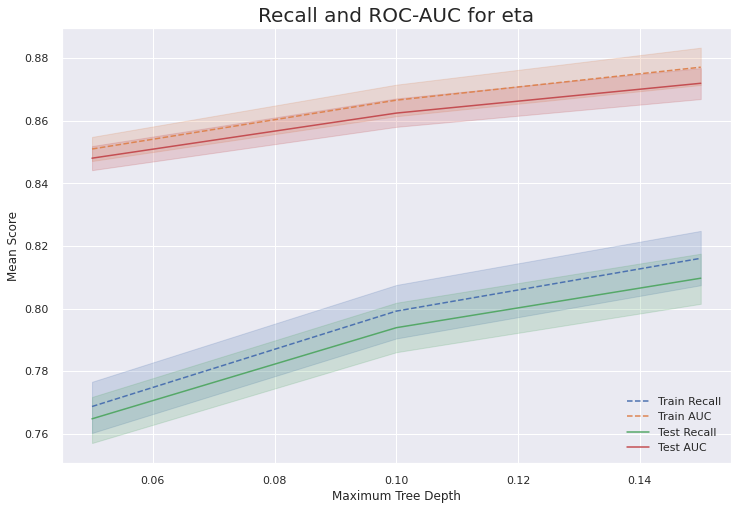

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Recall and ROC-AUC for eta',fontsize=20)

# training scores
sns.lineplot(x=results['param_eta'],
             y=results['mean_train_recall'],

             label='Train Recall',
             linestyle='--')
sns.lineplot(x=results['param_eta'],
             y=results['mean_train_roc_auc'],

             label='Train AUC',
             linestyle='--')

# testing scores
sns.lineplot(x=results['param_eta'],
             y=results['mean_test_recall'],

             label='Test Recall')
sns.lineplot(x=results['param_eta'],
             y=results['mean_test_roc_auc'],

             label='Test AUC')

plt.xlabel('eta')
plt.ylabel('Mean Score')
plt.legend(loc='lower right')
plt.show()

### Gamma Tuning

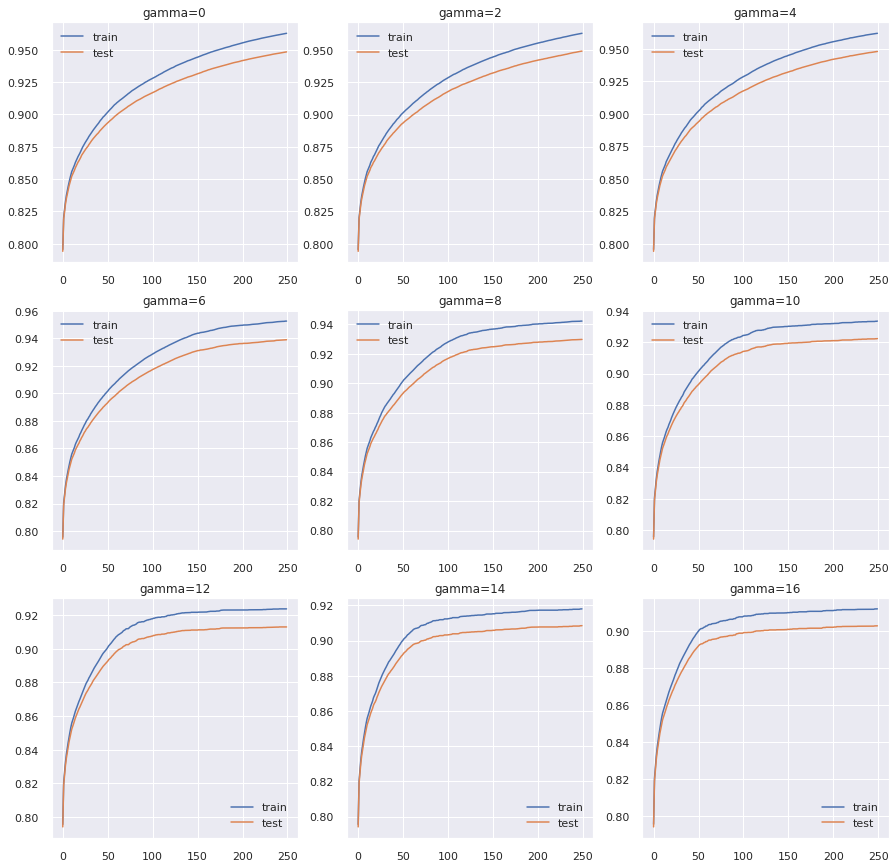

In [88]:
plt.figure(figsize=(15,15))

for i in range(9):
  # collect params and set gamma
  w=xgb_tuned1.get_params()
  w['gamma']=2*i

  # convert to XGB DMatrix format
  dmat=DMatrix(
      Xt_over,
      yt_over,
      enable_categorical=True
  )

  # cv
  a=XGB_CV(
      params=w,
      dtrain=dmat,
      num_boost_round=250,
      nfold=5,
      metrics={'auc'}
  )

  # subplot
  plt.subplot(3,3,i+1)
  plt.title(f'gamma={2*i}')
  plt.plot(np.arange(250),a['train-auc-mean'],label='train')
  plt.plot(np.arange(250),a['test-auc-mean'],label='test')
  plt.legend(loc='lower right')

clear_output()
plt.show()

In [116]:
w=xgb_tuned1.get_params()
w['gamma']=6

xgb_tuned2=XGBClassifier(**w)

xgb_tuned2.fit(Xt_over,yt_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=6, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

,Val. Scores
Accuracy,0.831185
Precision,0.125127
Recall,0.545455
F1,0.203558


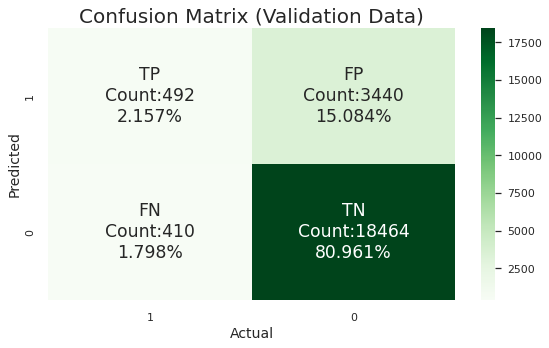

In [95]:
ch(xgb_tuned2)

In [117]:
get_scores(xgb_tuned2,sample='over',output='pandas')

,Recall,F_beta,F1,AUC,0-1_Loss
train,0.894224,0.882210,0.864782,0.860178,0.139822
val,0.606430,0.336326,0.201622,0.712433,0.189950


In [118]:
get_scores(xgb_tuned1,sample='over',output='pandas')

,Recall,F_beta,F1,AUC,0-1_Loss
train,0.889880,0.878905,0.862941,0.858662,0.141338
val,0.621951,0.341948,0.204111,0.718892,0.191835


## LightGBM